In [1]:
%run -n boillerplate.ipynb

# Figure 3 : Is decoding Bthetas and Thetas better to encode MotionClouds, rather than just learning Thetas ?

# Training the theta decoder (without splitting bthetas)

In [3]:
try:
    all_cms_theta_only = np.load('./data/fig_3_margin_only_t_cms.npy', allow_pickle = True)

except:
    
    # Loading data
    try:
        data = np.load('./data/data_all_bt.npy')
        labels = np.load('./data/labels_all_bt.npy')
    except:    
        # Data
        data, labels, le = par_load_temporal_data(timesteps = timesteps, target_btheta = None,
                                                  target_theta = None, data_type = 'all_bt',
                                                  cluster_list = cluster_list)
        np.save('./data/data_all_bt.npy', data)
        np.save('./data/labels_all_bt.npy', labels)

    # Kfolding CM
    all_cms_theta_only = np.zeros((len(timesteps), n_splits), dtype = object)
    for i, t in tqdm(enumerate(timesteps), total = len(timesteps), desc = 'Confusion matrixing'):
        d = data[i,:,:]
        kf = KFold(n_splits = n_splits)

        for i1, (train_index, test_index) in enumerate(kf.split(d, labels)):
            xtrain, xtest = d[train_index], d[test_index]
            ytrain, ytest = labels[train_index], labels[test_index]

            logreg = LogisticRegression(**opts_LR)
            logreg.fit(xtrain, ytrain)

            cm = metrics.confusion_matrix(ytest, logreg.predict(xtest), normalize = 'all')
            cm *= len(le.classes_)

            all_cms_theta_only[i, i1] = cm
            
    np.save('./data/fig_3_margin_only_t_cms.npy', all_cms_theta_only)
    


Confusion matrixing: 100%|██████████| 61/61 [36:17<00:00, 35.69s/it]


In [4]:
theta_cm_means = []
theta_cm_accs, theta_cm_stds = [], []
for i, t in enumerate(timesteps) :
    cm_mean = np.mean(all_cms_theta_only[i], axis = 0)
    cm_std = np.std(all_cms_theta_only[i], axis = 0)
    
    theta_cm_accs.append(np.mean(np.diagonal(cm_mean)))
    theta_cm_stds.append(np.mean(np.diagonal(cm_std)))
    theta_cm_means.append(cm_mean)
    
theta_cm_accs = np.asarray(theta_cm_accs) #/ 12
theta_cm_stds = np.asarray(theta_cm_stds) #/ 12
theta_cm_means = np.asarray(theta_cm_means) / 12

In [5]:
np.sum(np.diagonal(np.mean(all_cms_theta_only[40], axis = 0)))

7.4208333333333325

In [6]:
all_cms_theta_only[40][0].shape

(12, 12)

In [7]:
np.mean(all_cms_theta_only[40], axis = 0)

array([[0.74583333, 0.09166667, 0.0125    , 0.01666667, 0.00833333,
        0.        , 0.        , 0.00416667, 0.        , 0.00416667,
        0.01666667, 0.1       ],
       [0.06666667, 0.72083333, 0.15      , 0.02916667, 0.        ,
        0.00416667, 0.00833333, 0.        , 0.00416667, 0.        ,
        0.00833333, 0.00833333],
       [0.025     , 0.15833333, 0.575     , 0.11666667, 0.075     ,
        0.025     , 0.00416667, 0.00416667, 0.        , 0.00416667,
        0.        , 0.0125    ],
       [0.00833333, 0.03333333, 0.13333333, 0.60833333, 0.17083333,
        0.03333333, 0.0125    , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.01666667, 0.01666667, 0.07916667, 0.175     , 0.46666667,
        0.175     , 0.05      , 0.00833333, 0.00416667, 0.        ,
        0.        , 0.00833333],
       [0.00416667, 0.        , 0.00833333, 0.02916667, 0.17083333,
        0.65      , 0.075     , 0.02916667, 0.025     , 0.00833333,
        0.        ,

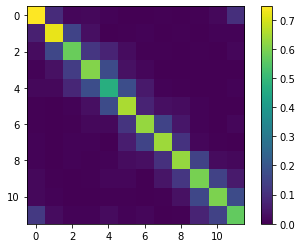

In [8]:
plt.imshow(np.mean(all_cms_theta_only[40], axis = 0))
plt.colorbar()

# Training the 96 decoder

In [9]:
try:
    all_cms_btt = np.load('./data/fig_3_margin_only_btt_cms.npy', allow_pickle = True)

except:
    # Loading data
    all_cms_btt = np.zeros((len(timesteps), n_splits), dtype = object)
    try:
        data = np.load('./data/data_all_t_bt.npy')
        labels = np.load('./data/labels_all_t_bt.npy')
    except:    
        # Data
        data, labels, le = par_load_temporal_data(timesteps = timesteps, target_btheta = None,
                                                  target_theta = None, data_type = 'all_t_bt',
                                                  cluster_list = cluster_list)
        np.save('./data/data_all_t_bt.npy', data)
        np.save('./data/labels_all_t_bt.npy', labels)

    # Kfolding CM
    for i, t in tqdm(enumerate(timesteps), total = len(timesteps), desc = 'Confusion matrixing'):
        d = data[i,:,:]
        kf = KFold(n_splits = n_splits)

        for i1, (train_index, test_index) in enumerate(kf.split(d, labels)):
            xtrain, xtest = d[train_index], d[test_index]
            ytrain, ytest = labels[train_index], labels[test_index]
            #if i < 15: # HACK to shuffle before stimulus onset
            #    np.random.shufle(ytrain)

            logreg = LogisticRegression(**opts_LR)
            logreg.fit(xtrain, ytrain)

            cm = metrics.confusion_matrix(ytest, logreg.predict(xtest), normalize = 'all')
            cm *= len(le.classes_)

            all_cms_btt[i, i1] = cm
            
    np.save('./data/fig_3_margin_only_btt_cms.npy', all_cms_btt)
    


Confusion matrixing: 100%|██████████| 61/61 [1:22:48<00:00, 81.45s/it]


In [10]:
all_cms_btt.shape

(61, 6)

In [11]:
# Recollapsing the 96 decoder
btt_cm_means = []
btt_cm_accs, btt_cm_stds = [], []
for i, t in enumerate(timesteps) :
    
    cm_mean_ = np.mean(all_cms_btt[i], axis = 0)
    margin_cm = []
    for x in np.arange(N_B_thetas):
        for y in np.arange(N_B_thetas):
            a = cm_mean_[x*N_thetas : (x+1)*N_thetas,
                         y*N_thetas : (y+1)*N_thetas]
            margin_cm.append(a)
    margin_cm = np.asarray(margin_cm)
    
    cm_mean = np.mean(margin_cm, axis = 0)
    btt_cm_means.append(cm_mean)
    btt_cm_accs.append(np.mean(np.diag(cm_mean)))
    
    # The standard deviation is the std of all possible diagonals 
    diags = []
    for mat in range(margin_cm.shape[0]) :
        diag = np.diag(margin_cm[mat])
        diags.append(diag)
    btt_cm_stds.append(np.std(diags))

    
btt_cm_accs = np.asarray(btt_cm_accs) *10
btt_cm_stds = np.asarray(btt_cm_stds)
btt_cm_means = np.asarray(btt_cm_means)

In [12]:
cm_mean_ = np.mean(all_cms_btt[40], axis = 0)

In [13]:
margin_cm = []
for x in np.arange(8):
    for y in np.arange(8):
        a = cm_mean_[x*12 : (x+1)*12,
              y*12 : (y+1)*12]
        margin_cm.append(a)
margin_cm = np.asarray(margin_cm)

In [14]:
(np.sum(np.diag(np.mean(margin_cm, axis = 0)))*10)/12

0.674045138888889

In [15]:
np.sum(np.diagonal(np.mean(all_cms_btt[40], axis = 0)))/12

1.2222222222222225

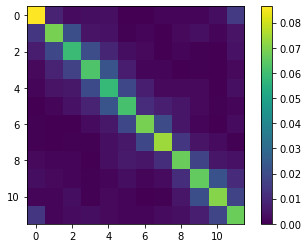

In [16]:
plt.imshow(np.mean(margin_cm, axis = 0))
plt.colorbar()

# Comparing time series

<ipython-input-17-f7e302ebb5ee>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels((labs*100).astype(np.int16))


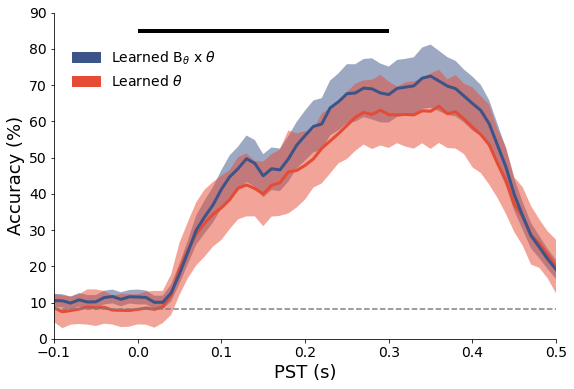

In [17]:
fig, ax = plt.subplots(figsize = (9, 6))
cols = plt.cm.viridis(np.linspace(.2, .8, 2))
cols = [r'#E64B35', r'#3C5488']

ax.plot(timesteps + win_size, theta_cm_accs, color = cols[0], linewidth = 3)
ax.plot(timesteps + win_size, btt_cm_accs, color = cols[1], linewidth = 3)

ax.fill_between(timesteps + win_size,
                btt_cm_accs + btt_cm_stds, btt_cm_accs - btt_cm_stds,
                facecolor = cols[1], edgecolor = None, alpha = .5,
                label = r'Learned B$_\theta$ x $\theta$')
ax.fill_between(timesteps + win_size,
                theta_cm_accs + theta_cm_stds, theta_cm_accs - theta_cm_stds,
                facecolor = cols[0], edgecolor = None, alpha = .5,
                label = r'Learned $\theta$')


ax.hlines(.85, 0., .3, color = 'k', linewidth = 4)
ax.axhline(1/12, c = 'gray', linestyle = '--')

ax.legend(loc = (.025, .75), frameon = False, fontsize = 14, markerscale = .3)
leg = ax.get_legend()
leg.legendHandles[0].set_color(cols[1])
leg.legendHandles[0].set_alpha(1)
leg.legendHandles[1].set_color(cols[0])
leg.legendHandles[1].set_alpha(1)

ax.set_xlim(timesteps[0]+win_size, timesteps[-1]+win_size)
ax.set_ylim(0, .9)

ax.set_xlabel('PST (s)', fontsize = 18)
ax.set_ylabel('Accuracy (%)', fontsize = 18)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=14)
labs = np.round(ax.get_yticks().tolist(),1)
ax.set_yticklabels((labs*100).astype(np.int16))

fig.savefig('./output/fig_3_marginalization_timecourse.pdf', bbox_inches='tight', dpi=200, transparent=True)

plt.show()

<ipython-input-18-9817feb55122>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels((labs*100).astype(np.int16))


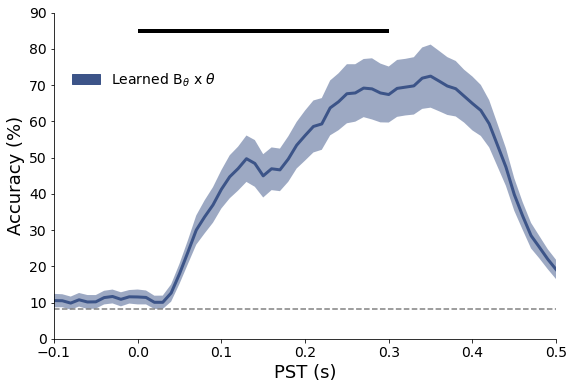

In [18]:
fig, ax = plt.subplots(figsize = (9, 6))
cols = plt.cm.viridis(np.linspace(.2, .8, 2))
cols = [r'#E64B35', r'#3C5488']

ax.plot(timesteps + win_size, btt_cm_accs, color = cols[1], linewidth = 3)

ax.fill_between(timesteps + win_size,
                btt_cm_accs + btt_cm_stds, btt_cm_accs - btt_cm_stds,
                facecolor = cols[1], edgecolor = None, alpha = .5,
                label = r'Learned B$_\theta$ x $\theta$')


ax.hlines(.85, 0., .3, color = 'k', linewidth = 4)
ax.axhline(1/12, c = 'gray', linestyle = '--')

ax.legend(loc = (.025, .75), frameon = False, fontsize = 14, markerscale = .3)
leg = ax.get_legend()
leg.legendHandles[0].set_color(cols[1])
leg.legendHandles[0].set_alpha(1)

ax.set_xlim(timesteps[0]+win_size, timesteps[-1]+win_size)
ax.set_ylim(0, .9)

ax.set_xlabel('PST (s)', fontsize = 18)
ax.set_ylabel('Accuracy (%)', fontsize = 18)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=14)
labs = np.round(ax.get_yticks().tolist(),1)
ax.set_yticklabels((labs*100).astype(np.int16))

fig.savefig('./output/fig_3_marginalization_timecourse_btheta.pdf', bbox_inches='tight', dpi=200, transparent=True)

plt.show()

<ipython-input-19-e0413a60cd5e>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels((labs*100).astype(np.int16))


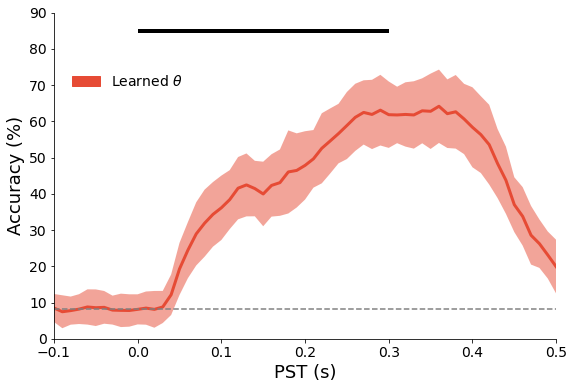

In [19]:
fig, ax = plt.subplots(figsize = (9, 6))
cols = plt.cm.viridis(np.linspace(.2, .8, 2))
cols = [r'#E64B35', r'#3C5488']

ax.plot(timesteps + win_size, theta_cm_accs, color = cols[0], linewidth = 3)
ax.fill_between(timesteps + win_size,
                theta_cm_accs + theta_cm_stds, theta_cm_accs - theta_cm_stds,
                facecolor = cols[0], edgecolor = None, alpha = .5,
                label = r'Learned $\theta$')


ax.hlines(.85, 0., .3, color = 'k', linewidth = 4)
ax.axhline(1/12, c = 'gray', linestyle = '--')

ax.legend(loc = (.025, .75), frameon = False, fontsize = 14, markerscale = .3)
leg = ax.get_legend()
leg.legendHandles[0].set_color(cols[0])
leg.legendHandles[0].set_alpha(1)

ax.set_xlim(timesteps[0]+win_size, timesteps[-1]+win_size)
ax.set_ylim(0, .9)

ax.set_xlabel('PST (s)', fontsize = 18)
ax.set_ylabel('Accuracy (%)', fontsize = 18)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=14)
labs = np.round(ax.get_yticks().tolist(),1)
ax.set_yticklabels((labs*100).astype(np.int16))

fig.savefig('./output/fig_3_marginalization_timecourse_theta.pdf', bbox_inches='tight', dpi=200, transparent=True)

plt.show()

In [20]:
print(f'{timesteps[0]=:.3f}')

timesteps[0]=-0.200


# Comparing confusion matrix

In [22]:
# Marginalize each K-fold, so we compare the same thing with stats
marg_stats = []
for i, t in enumerate(timesteps) :
    cm = all_cms_btt[i,:]
    margin_cms = []
    for i1 in range(cm.shape[0]) :
        margin_cm = []
        for x in np.arange(8):
            for y in np.arange(8):
                a = cm[i1][(x*12) : (x*12) + 12,
                           (y*12) : (y*12) + 12]
                margin_cm.append(a)
        margin_cm = np.asarray(margin_cm)
        margin_cms.append(np.mean(margin_cm, axis = 0))
    marg_stats.append(margin_cms)
    
marg_stats = np.asarray(marg_stats)

In [23]:
print('Marginalized on trials array shape : ' + str(marg_stats.shape))
print('Theta only shape : ' + str(all_cms_theta_only.shape) + ' ' + str(all_cms_theta_only[0][0].shape))

Marginalized on trials array shape : (61, 6, 12, 12)
Theta only shape : (61, 6) (12, 12)


In [24]:
try:
    all_p_mats = np.load('./data/fig_3_margin_pvals.npy', allow_pickle = True)

except:
    mshape = 12
    all_p_mats = np.zeros(len(timesteps), dtype = object) #pval
    for it, __ in tqdm(enumerate(timesteps), total = len(timesteps)):

        wil_mats = np.zeros((mshape,mshape))
        p_mats = np.zeros((mshape,mshape))
        for i1 in range(mshape) :
            for i2 in range(mshape) :

                bt_pix = []
                for i3 in range(n_splits) :
                    pix = all_cms_theta_only[it, i3][i1, i2]
                    bt_pix.append(pix)

                t_pix = [] 
                for i3 in range(n_splits) :
                    pix = marg_stats[it, i3][i1, i2]
                    t_pix.append(pix)

                try:
                     p = permutation_test(bt_pix, t_pix)
                except ValueError :
                    p = 20,20 #identical values, skip the test by putting a large pval
                #wil_mats[i1, i2] = w
                p_mats[i1, i2] = p

        all_p_mats[it] = p_mats
        
    np.save('./data/fig_3_margin_pvals.npy', all_p_mats)
    


100%|██████████| 61/61 [05:21<00:00,  5.28s/it]


<ipython-input-25-ea65ffbe3f08>:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(h_pad = .3, w_pad = 1.)


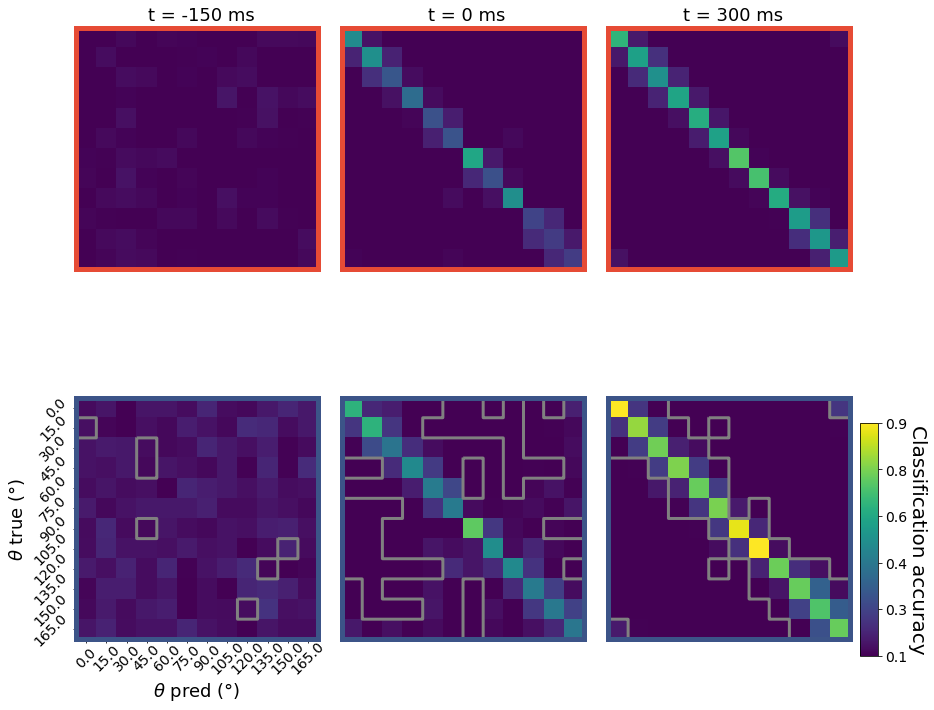

In [25]:
fig, axs = plt.subplots(figsize = (12,12), nrows = 2, ncols = 3)

t_idxs = [5, 20, 50]

# Theta only
for i in range(3) :
    ax = axs[0,i]
    t = t_idxs[i]
    cm = theta_cm_means[t]*12
    
    ims = ax.imshow(cm, vmin = 1/12, vmax = np.max(btt_cm_means[t_idxs[-1]])*12, aspect = 'equal')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.autoscale(False)
    
    for edge in ['top', 'bottom', 'left', 'right'] :
            ax.spines[edge].set_color(r'#E64B35')
            ax.spines[edge].set_linewidth(5)
    
    '''if i == 2 :
        cax = fig.add_axes([ax.get_position().x1+0.1, # offset from the right of the axis
                                ax.get_position().y0+-.048, #bottom of the colorbar
                                0.02, #width of the colorbar
                                .27]) #height of the colorbar
        cb = fig.colorbar(ims, cax = cax, ticks = np.linspace(1/12, np.max(theta_cm_means[t_idxs[-1]])*12, 6))
        cb.ax.set_yticklabels(np.round(np.linspace(1/12, np.max(theta_cm_means[t_idxs[-1]])*12, 6), 1))
        cb.ax.tick_params(labelsize = 14)
        cax.set_ylabel('Classification accuracy', rotation = 270, labelpad = 20,
                      fontsize = 20)'''
        
    if i == 0 :
        ax.text(x = (cm.shape[0] /2)-.3, y = -1.1, s = 't = -150 ms', fontsize = 18,
                   va = 'center', ha = 'center')
    elif i == 1 :
        ax.text(x = (cm.shape[0] /2)-.3, y = -1.1, s = 't = 0 ms', fontsize = 18,
               va = 'center', ha = 'center')
    elif i ==2 :
        ax.text(x = (cm.shape[0] /2)-.3, y = -1.1, s = 't = 300 ms', fontsize = 18,
               va = 'center', ha = 'center')
        
        
    
# BTT marginalized
for i in range(3):
    ax = axs[1,i]
    t = t_idxs[i]
    cm = btt_cm_means[t]*12
    
    pvals = all_p_mats[t]
    pval_edges(pvals < .05, ax = ax, c = 'gray')
    
    ims = ax.imshow(cm, vmin = 1/12, vmax = np.max(btt_cm_means[t_idxs[-1]])*12, aspect = 'equal')
    
    ax.autoscale(False)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.autoscale(False)
    ax.set_xlim(-.5, 11.5)
    ax.set_ylim(11.5, -.5)
    
    for edge in ['top', 'bottom', 'left', 'right'] :
            ax.spines[edge].set_color(r'#3C5488')
            ax.spines[edge].set_linewidth(5)
    
    if i == 0:
        ax.set_xlabel(r'$\theta$ pred (°)', fontsize = 18)
        ax.set_ylabel(r'$\theta$ true (°)', fontsize = 18)
        ax.tick_params(axis='x', which='major', pad=15)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_xticks(np.arange(0, 12))
        ax.set_yticks(np.arange(0, 12))
        ax.set_xticklabels(np.round(thetas*180/np.pi,1), rotation = 45, va = 'center')
        ax.set_yticklabels(np.round(thetas*180/np.pi,1), rotation = 45, va = 'center')
        
    if i == 2 :
        cax = fig.add_axes([ax.get_position().x1+0.1, # offset from the right of the axis
                                ax.get_position().y0+-.048, #bottom of the colorbar
                                0.02, #width of the colorbar
                                .27]) #height of the colorbar
        cb = fig.colorbar(ims, cax = cax, ticks = np.linspace(1/12, np.max(btt_cm_means[t_idxs[-1]])*12, 6))
        cb.ax.set_yticklabels(np.round(np.linspace(1/12, np.max(btt_cm_means[t_idxs[-1]])*12, 6), 1))
        cb.ax.tick_params(labelsize = 14)
        cax.set_ylabel('Classification accuracy', rotation = 270, labelpad = 20,
                      fontsize = 20)

    
fig.tight_layout(h_pad = .3, w_pad = 1.)

fig.savefig('./output/fig_3_marginalization_confmats.pdf', bbox_inches='tight', dpi=200, transparent=True)

plt.show()

In [26]:
for i, t in enumerate(t_idxs):
    pvals = all_p_mats[t]
    signif = pvals < .05
    n_diag = len(np.where(np.diag(signif) == True)[0])
    n_all = len(np.where(signif == True)[0])
    print('t = %.2fs, \t %s/%s at pvals <.05 (diag significative = %s/%s)' % (timesteps[t],
                                         n_all, 12*12, n_diag, 12))

t = -0.15s, 	 137/144 at pvals <.05 (diag significative = 11/12)
t = 0.00s, 	 104/144 at pvals <.05 (diag significative = 12/12)
t = 0.30s, 	 49/144 at pvals <.05 (diag significative = 12/12)
